## Import libraries

In [50]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import chain
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import json

# ingnore future warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [28]:
# Load data
cuisine_df = pd.read_csv('../data/RAW_recipes_cleaned.csv')
cuisine_df.head()

,id,name,Cuisine_Tags_str,replaced_ingredients_str,steps_str,tags_str,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,Cuisine_Tags,replaced_ingredients
0,137739,arriba baked winter squash mexican style,mexican,winter squash mexican seasoning mixed spice ho...,make a choice and proceed with recipe dependin...,60-minutes-or-less time-to-make course main-in...,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,['mexican'],"['winter squash', 'mexican seasoning', 'mixed ..."
1,31490,a bit different breakfast pizza,northeastern-united-states,pizza crust sausage egg milk salt and pepper c...,preheat oven to 425 degrees f press dough into...,30-minutes-or-less time-to-make course main-in...,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,['northeastern-united-states'],"['pizza crust', 'sausage', 'egg', 'milk', 'sal..."
2,44061,amish tomato ketchup for canning,northeastern-united-states,tomato juice apple cider vinegar sugar salt pe...,"mix all ingredients& boil for 2 1 / 2 hours , ...",weeknight time-to-make course main-ingredient ...,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,['northeastern-united-states'],"['tomato juice', 'apple cider vinegar', 'sugar..."
3,25274,aww marinated olives,canadian,fennel seed green olive ripe olive garlic pepp...,toast the fennel seeds and lightly crush them ...,15-minutes-or-less time-to-make course main-in...,15,21730,2002-04-14,"['15-minutes-or-less', 'time-to-make', 'course...","[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,"['fennel seed', 'green olive', 'ripe olive', '...",9,['canadian'],"['fennel seed', 'green olive', 'ripe olive', '..."
4,43026,chile rellenos,southwestern-united-states,egg roll wrap whole green chili cheese cornsta...,drain green chiles sprinkle cornstarch on shee...,60-minutes-or-less time-to-make course main-in...,45,52268,2002-10-14,"['60-minutes-or-less', 'time-to-make', 'course...","[94.0, 10.0, 0.0, 11.0, 11.0, 21.0, 0.0]",9,"['drain green chiles', 'sprinkle cornstarch on...",a favorite from a local restaurant no longer i...,"['egg roll wrap', 'whole green chili', 'cheese...",5,['southwestern-united-states'],"['egg roll wrap', 'whole green chili', 'cheese..."


## Data preprocessing

In [29]:
# Convert string to list
cuisine_df['tags'] = cuisine_df['tags'].apply(ast.literal_eval)
cuisine_df['steps'] = cuisine_df['steps'].apply(ast.literal_eval)
cuisine_df['replaced_ingredients'] = cuisine_df['replaced_ingredients'].apply(ast.literal_eval)
cuisine_df['Cuisine_Tags'] = cuisine_df['Cuisine_Tags'].apply(ast.literal_eval)

In [30]:
# Create a list of all ingredients
all_ingredients_list = list(set(chain.from_iterable(cuisine_df['replaced_ingredients'])))
# Create a binary matrix for the ingredients
mlb = MultiLabelBinarizer(classes=all_ingredients_list)
# Fit and transform the data
ingredient_matrix = mlb.fit_transform(cuisine_df['replaced_ingredients'])
# Create a DataFrame for the binary matrix
ingredient_df = pd.DataFrame(ingredient_matrix, columns=mlb.classes_, index=cuisine_df.index)
ingredient_df['Cuisine_Tags']=cuisine_df['Cuisine_Tags']
ingredient_df.head()

,shrimp,brut champagne,ajwain,hen,liquid certo,frozen green bean,chocolate-covered espresso bean,galangal,kefalograviera cheese,brown bean,...,shrimp ramen noodle soup,tagliolini,lemon slouse,ciclon,shaoxing wine,orange rind,canning salt,dumpling,pandan leaf,Cuisine_Tags
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[mexican]
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[northeastern-united-states]
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[northeastern-united-states]
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,[canadian]
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[southwestern-united-states]


In [38]:
# Add the cuisine column
ingredient_df['Cuisine'] = ingredient_df['Cuisine_Tags'].apply(lambda x: x[0])
# Aggregate by cuisine
cuisine_ingredient_matrix = ingredient_df.groupby('Cuisine').sum()
# Drop the Cuisine_Tags column
cuisine_ingredient_matrix.drop(columns=['Cuisine_Tags'], inplace=True)

In [39]:
cuisine_ingredient_matrix.head()

,shrimp,brut champagne,ajwain,hen,liquid certo,frozen green bean,chocolate-covered espresso bean,galangal,kefalograviera cheese,brown bean,...,frozen broccoli floret,shrimp ramen noodle soup,tagliolini,lemon slouse,ciclon,shaoxing wine,orange rind,canning salt,dumpling,pandan leaf
Cuisine,,,,,,,,,,,,,,,,,,,,,
australian,6,1,0,0,0,1,0,0,0,0,...,0,0,0,5,0,0,25,0,0,0
austrian,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
belgian,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
brazilian,7,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,2,1,0,0
canadian,26,1,0,0,0,2,0,0,0,0,...,1,0,0,6,0,0,44,1,0,0


In [41]:
# Create a correlation matrix
Correlation_Matrix = cuisine_ingredient_matrix.T.corr()
Correlation_Matrix

Cuisine,australian,austrian,belgian,brazilian,canadian,chilean,chinese,colombian,cuban,czech,...,southern-united-states,southwestern-united-states,spanish,swedish,swiss,thai,turkish,venezuelan,vietnamese,welsh
Cuisine,,,,,,,,,,,,,,,,,,,,,
australian,1.000000,0.726662,0.756216,0.814653,0.851981,0.764738,0.494660,0.706477,0.719441,0.693520,...,0.800326,0.674957,0.779851,0.737557,0.809279,0.511167,0.795450,0.724883,0.494528,0.726897
austrian,0.726662,1.000000,0.857151,0.751598,0.873112,0.627003,0.418139,0.649820,0.566203,0.916734,...,0.843304,0.587191,0.546238,0.932061,0.869360,0.353336,0.670082,0.675747,0.413463,0.798587
belgian,0.756216,0.857151,1.000000,0.758020,0.873952,0.677745,0.406716,0.683307,0.624784,0.818457,...,0.841618,0.618871,0.613214,0.848371,0.882593,0.377778,0.702176,0.684944,0.407974,0.804309
brazilian,0.814653,0.751598,0.758020,1.000000,0.846453,0.872883,0.526328,0.822020,0.834270,0.726975,...,0.846853,0.774699,0.813905,0.752065,0.787017,0.580270,0.843231,0.850698,0.601468,0.635433
canadian,0.851981,0.873112,0.873952,0.846453,1.000000,0.763667,0.518773,0.765151,0.708472,0.847740,...,0.944746,0.745343,0.697161,0.892443,0.892655,0.475780,0.794170,0.751434,0.492505,0.812596
chilean,0.764738,0.627003,0.677745,0.872883,0.763667,1.000000,0.483162,0.809758,0.857810,0.604227,...,0.768641,0.806299,0.854414,0.609162,0.694486,0.552517,0.847683,0.834990,0.554496,0.552656
chinese,0.494660,0.418139,0.406716,0.526328,0.518773,0.483162,1.000000,0.546949,0.447200,0.407763,...,0.524733,0.468485,0.415376,0.429334,0.447833,0.728454,0.449307,0.488326,0.696487,0.320081
colombian,0.706477,0.649820,0.683307,0.822020,0.765151,0.809758,0.546949,1.000000,0.728769,0.655813,...,0.771003,0.754899,0.689969,0.670752,0.708014,0.542563,0.781049,0.796299,0.565178,0.590330
cuban,0.719441,0.566203,0.624784,0.834270,0.708472,0.857810,0.447200,0.728769,1.000000,0.523958,...,0.723394,0.794831,0.860985,0.539026,0.635903,0.522925,0.822919,0.737785,0.523869,0.433506


## Model building

In [43]:
# Create a distance matrix
distance_matrix = 1 - Correlation_Matrix
# Convert the distance matrix to a condensed form
condensed_distance_matrix = squareform(distance_matrix)
# Create a linkage matrix
linked = linkage(condensed_distance_matrix, method='average')

In [44]:
# Create a dendrogram
num_clusters =20
cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

# Add cluster labels to the cuisine data
cuisine_clusters = pd.DataFrame({
    'Cuisine': Correlation_Matrix.index,
    'Cluster': cluster_labels
})

print(cuisine_clusters)

                       Cuisine  Cluster
0                   australian       19
1                     austrian       17
2                      belgian       17
3                    brazilian        9
4                     canadian       17
5                      chilean        9
6                      chinese        1
7                    colombian       10
8                        cuban       13
9                        czech       17
10                      danish       17
11                       dutch       17
12                    egyptian       12
13                     english       17
14                   ethiopian        7
15                    filipino        3
16                     finnish       17
17                      french       17
18                    georgian       20
19                      german       17
20                       greek       15
21                   hungarian       16
22                      indian        6
23                  indonesian        2


In [45]:
# Group the data by cluster
clusters = cuisine_clusters.groupby('Cluster')['Cuisine'].apply(list)

# Display cuisines in each cluster
for cluster_num, cuisines in clusters.items():
    print(f"Cluster {cluster_num}: {', '.join(cuisines)}")

Cluster 1: chinese, japanese, korean
Cluster 2: indonesian, malaysian
Cluster 3: filipino
Cluster 4: thai, vietnamese
Cluster 5: laotian
Cluster 6: indian, pakistani
Cluster 7: ethiopian
Cluster 8: mexican, southwestern-united-states
Cluster 9: brazilian, chilean, venezuelan
Cluster 10: colombian
Cluster 11: peruvian
Cluster 12: egyptian, iranian-persian, iraqi, saudi-arabian
Cluster 13: cuban, puerto-rican
Cluster 14: libyan, moroccan
Cluster 15: greek, italian, lebanese, palestinian, portuguese, spanish, turkish
Cluster 16: hungarian, russian
Cluster 17: austrian, belgian, canadian, czech, danish, dutch, english, finnish, french, german, new-zealand, northeastern-united-states, norwegian, polish, scottish, south-african, southern-united-states, swedish, swiss
Cluster 18: welsh
Cluster 19: australian
Cluster 20: georgian


In [46]:
clusters

Cluster
1                           [chinese, japanese, korean]
2                               [indonesian, malaysian]
3                                            [filipino]
4                                    [thai, vietnamese]
5                                             [laotian]
6                                   [indian, pakistani]
7                                           [ethiopian]
8                 [mexican, southwestern-united-states]
9                      [brazilian, chilean, venezuelan]
10                                          [colombian]
11                                           [peruvian]
12    [egyptian, iranian-persian, iraqi, saudi-arabian]
13                                [cuban, puerto-rican]
14                                   [libyan, moroccan]
15    [greek, italian, lebanese, palestinian, portug...
16                                 [hungarian, russian]
17    [austrian, belgian, canadian, czech, danish, d...
18                                      

In [49]:
# Convert the Series to a dictionary
clusters_dict = clusters.to_dict()
clusters_dict

{1: ['chinese', 'japanese', 'korean'],
 2: ['indonesian', 'malaysian'],
 3: ['filipino'],
 4: ['thai', 'vietnamese'],
 5: ['laotian'],
 6: ['indian', 'pakistani'],
 7: ['ethiopian'],
 8: ['mexican', 'southwestern-united-states'],
 9: ['brazilian', 'chilean', 'venezuelan'],
 10: ['colombian'],
 11: ['peruvian'],
 12: ['egyptian', 'iranian-persian', 'iraqi', 'saudi-arabian'],
 13: ['cuban', 'puerto-rican'],
 14: ['libyan', 'moroccan'],
 15: ['greek',
  'italian',
  'lebanese',
  'palestinian',
  'portuguese',
  'spanish',
  'turkish'],
 16: ['hungarian', 'russian'],
 17: ['austrian',
  'belgian',
  'canadian',
  'czech',
  'danish',
  'dutch',
  'english',
  'finnish',
  'french',
  'german',
  'new-zealand',
  'northeastern-united-states',
  'norwegian',
  'polish',
  'scottish',
  'south-african',
  'southern-united-states',
  'swedish',
  'swiss'],
 18: ['welsh'],
 19: ['australian'],
 20: ['georgian']}

## Save the clusters

In [52]:
# Save the dictionary to a JSON file
with open('../data/cuisine_clusters.json', 'w') as f:
    json.dump(clusters_dict, f, indent=4)

## Using Elbow method to determine clusters, but the model contain same cuisine type in different clusters

In [12]:
# # Initialize the TF-IDF Vectorizer
# tfidf = TfidfVectorizer()

# # Transform the `replaced_ingredients_str` column
# tfidf_matrix = tfidf.fit_transform(cuisine_df['replaced_ingredients_str'])
# print(tfidf_matrix.shape)

(50399, 2891)


c:\Users\ldscs\anaconda3\envs\zero-waste-recipe\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ldscs\anaconda3\envs\zero-waste-recipe\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ldscs\anaconda3\envs\zero-waste-recipe\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ldscs\anaconda3\envs\zero-waste-recipe\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

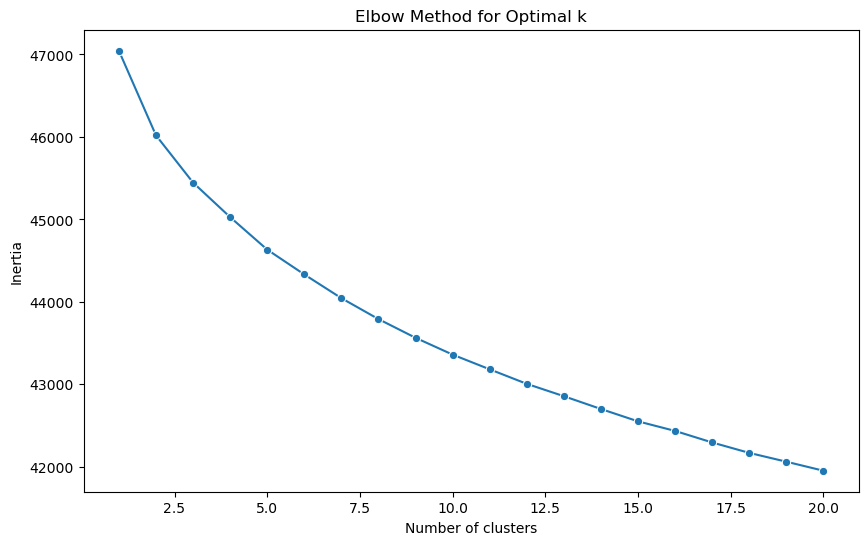

In [16]:
# # Determine the number of clusters using the elbow method
# inertia = []
# k_values = range(1, 58)
# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(tfidf_matrix)
#     inertia.append(kmeans.inertia_)

# # Plot the elbow curve
# plt.figure(figsize=(10, 6))
# sns.lineplot(x=k_values, y=inertia, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal k')
# plt.show()

In [17]:
# # Choose an optimal number of clusters (for example, k=10 based on the elbow plot)
# optimal_k = 4
# kmeans = KMeans(n_clusters=optimal_k, random_state=42)
# cuisine_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# # Print the cluster assignments
# print(cuisine_df[['Cuisine_Tags_str', 'cluster']].head())

c:\Users\ldscs\anaconda3\envs\zero-waste-recipe\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


             Cuisine_Tags_str  cluster
0                     mexican        0
1  northeastern-united-states        0
2  northeastern-united-states        1
3                    canadian        1
4  southwestern-united-states        0


In [18]:
# # Analyze the clustering results
# cluster_counts = cuisine_df['cluster'].value_counts().sort_index()
# print(cluster_counts)

# # Show examples of each cluster
# for cluster_num in range(optimal_k):
#     print(f"\nCluster {cluster_num}:")
#     print(cuisine_df[cuisine_df['cluster'] == cluster_num]['Cuisine_Tags_str'].value_counts().head())

cluster
0    18259
1    12700
2     6784
3    12656
Name: count, dtype: int64

Cluster 0:
Cuisine_Tags_str
southern-united-states    2903
mexican                   2398
canadian                  1840
italian                   1718
australian                1135
Name: count, dtype: int64

Cluster 1:
Cuisine_Tags_str
italian                   4490
greek                     1486
southern-united-states    1027
canadian                   759
french                     668
Name: count, dtype: int64

Cluster 2:
Cuisine_Tags_str
southern-united-states        1109
canadian                       870
italian                        545
northeastern-united-states     411
german                         357
Name: count, dtype: int64

Cluster 3:
Cuisine_Tags_str
mexican                       2386
indian                        1884
chinese                       1523
southern-united-states        1238
southwestern-united-states    1009
Name: count, dtype: int64
